<a href="https://colab.research.google.com/github/killian31/SimpleNNViz/blob/main/circle_separ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks Hidden Representations Visualized

Created by Killian Steunou

In [53]:
#@markdown #**Useful functions, imports and data structures**
#@markdown ---

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import plotly.graph_objects as go

def list_of_tuples_to_numpy(lst):
    return np.array(lst)

# Function to generate points inside a circle
def generate_points_inside_circle(num_points, circle_center, circle_radius):
    points = []
    while len(points) < num_points:
        x1 = np.random.uniform(0, 10)
        x2 = np.random.uniform(0, 10)
        if (x1 - circle_center[0])**2 + (x2 - circle_center[1])**2 <= circle_radius**2:
            points.append((x1, x2))
    return points

# Function to generate points outside a circle
def generate_points_outside_circle(num_points, circle_center, circle_radius):
    points = []
    while len(points) < num_points:
        x1 = np.random.uniform(0, 10)
        x2 = np.random.uniform(0, 10)
        if (x1 - circle_center[0])**2 + (x2 - circle_center[1])**2 > circle_radius**2:
            points.append((x1, x2))
    return points

# Function to plot decision boundary
def plot_decision_boundary(model, points_inside, points_outside):
    plt.figure(figsize=(8, 8))

    # Convert points to NumPy arrays
    points_inside = list_of_tuples_to_numpy(points_inside)
    points_outside = list_of_tuples_to_numpy(points_outside)

    # Plot points inside and outside the circle
    plt.scatter(points_inside[:, 0], points_inside[:, 1], color='blue', label='Inside Circle')
    plt.scatter(points_outside[:, 0], points_outside[:, 1], color='red', label='Outside Circle')

    # Plot decision boundary
    x_min, x_max = 0, 10
    y_min, y_max = 0, 10
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    input_data = np.c_[xx.ravel(), yy.ravel()]
    inputs = torch.tensor(input_data, dtype=torch.float32)
    outputs = model(inputs).detach().numpy().reshape(xx.shape)
    plt.contour(xx, yy, outputs, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)

    plt.title('Decision Boundary of the Neural Network')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
    plt.show()

def plot_interactive_3d_latent_space(model, points, labels):
    model.eval()
    with torch.no_grad():
        inputs = points.clone().detach()
        hidden_activations = model.fc1(inputs)
        hidden_activations = model.relu1(hidden_activations)
        hidden_activations = model.fc2(hidden_activations)
        hidden_activations = model.relu2(hidden_activations)
        hidden_activations = model.fc3(hidden_activations)

    fig = go.Figure()

    # Scatter plot colored by labels (0 or 1)
    fig.add_trace(go.Scatter3d(
        x=hidden_activations[:, 0],
        y=hidden_activations[:, 1],
        z=hidden_activations[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        )
    ))

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Hidden Unit 1',
            yaxis_title='Hidden Unit 2',
            zaxis_title='Hidden Unit 3',
        ),
        scene_camera=dict(
            eye=dict(x=1.87, y=0.88, z=-0.64),
            up=dict(x=0, y=0, z=1),
        )
    )

    fig.show()

class CustomDataset(Dataset):
    def __init__(self, points_inside, points_outside):
        self.data = torch.tensor(points_inside + points_outside, dtype=torch.float32)
        self.labels = torch.tensor([0] * len(points_inside) + [1] * len(points_outside), dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

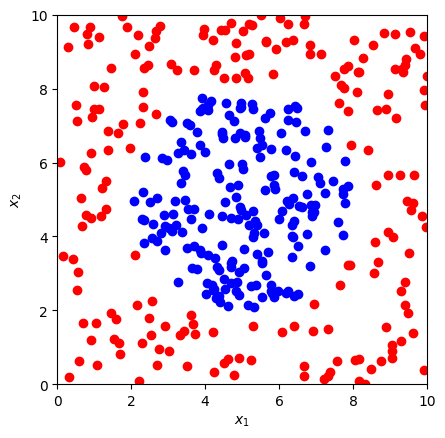

In [49]:
#@markdown #**Generate the dataset**
#@markdown ---
circle_center_x =  5#@param {type:"number"}
circle_center_y =  5#@param {type:"number"}
circle_radius = 3#@param {type:"number"}
number_points_inside = 200#@param {type:"number"}
number_points_outside = 200#@param {type:"number"}

# Circle parameters
circle_center = (circle_center_x, circle_center_y)

# Generate points inside and outside the circle
points_inside = generate_points_inside_circle(number_points_inside, circle_center, circle_radius)
points_outside = generate_points_outside_circle(number_points_outside, circle_center, circle_radius + 0.2)

# Display the points
points_inside_plot = np.array(points_inside)
points_outside_plot = np.array(points_outside)

plt.scatter(points_inside_plot[:, 0], points_inside_plot[:, 1], color='blue', label='Inside Circle')
plt.scatter(points_outside_plot[:, 0], points_outside_plot[:, 1], color='red', label='Outside Circle')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
#plt.legend()
plt.show()

In [50]:
#@markdown #**Create the model**
#@markdown ---

class SimpleNN3D(nn.Module):
    def __init__(self):
        super(SimpleNN3D, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Input layer (2 inputs, 10 hidden units)
        self.relu1 = nn.ReLU()       # Activation function for the first hidden layer
        self.fc2 = nn.Linear(10, 10) # Second hidden layer (10 hidden units)
        self.relu2 = nn.ReLU()       # Activation function for the second hidden layer
        self.fc3 = nn.Linear(10, 3)  # Third hidden layer (3 hidden units)
        self.relu3 = nn.ReLU()       # Activation function for the third hidden layer
        self.fc4 = nn.Linear(3, 1)   # Output layer (1 output)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return torch.sigmoid(x)  # Applying sigmoid activation for binary classification

model_3d = SimpleNN3D()
print(model_3d)

SimpleNN3D(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=10, out_features=3, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=3, out_features=1, bias=True)
)


Epoch 300/300, Loss: 0.0038, Accuracy: 99.75%: 100%|██████████| 300/300 [00:17<00:00, 17.40it/s]


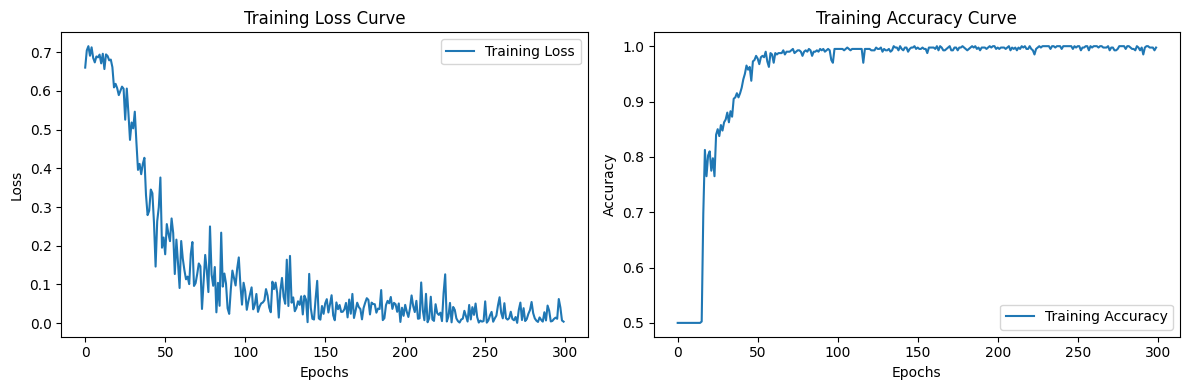

---
Training Accuracy: 99.75%


In [51]:
#@markdown #**Train the model**
#@markdown ---

epochs = 300#@param {type:"number"}
optimizer = "adam" #@param ["adam", "sgd"]
learning_rate =  0.001#@param {type:"number"}
batch_size = 16#@param {type:"number"}

# Create a custom dataset
custom_dataset = CustomDataset(points_inside, points_outside)

# Create a data loader
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

# Initialize the loss function, and optimizer

criterion = nn.BCELoss()
if optimizer == 'adam':
  optimizer = optim.Adam(model_3d.parameters(), lr=learning_rate)
elif optimizer == 'sgd':
  optimizer = optim.SGD(model_3d.parameters(), lr=learning_rate)

losses = []
accuracies = []

# Training loop
with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        model_3d.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model_3d(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

        # Compute accuracy
        model_3d.eval()
        with torch.no_grad():
            all_inputs = custom_dataset.data.clone().detach()
            all_labels = custom_dataset.labels.clone().detach().view(-1, 1)
            predictions = model_3d(all_inputs)
            predictions_rounded = predictions.round()
            accuracy = torch.sum(predictions_rounded == all_labels).item() / len(all_labels)
            accuracies.append(accuracy)

        # Store loss and update progress bar
        losses.append(loss.item())
        pbar.set_description(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%')
        pbar.update(1)

# Plot learning curves
plt.figure(figsize=(12, 4))

# Plot Loss curve
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Plot Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model on the training set
model_3d.eval()
with torch.no_grad():
    all_inputs = custom_dataset.data.clone().detach()
    all_labels = custom_dataset.labels.clone().detach().view(-1, 1)
    predictions = model_3d(all_inputs)
    predictions_rounded = predictions.round()
    accuracy = torch.sum(predictions_rounded == all_labels).item() / len(all_labels)
    print(f'---\nTraining Accuracy: {accuracy * 100:.2f}%')

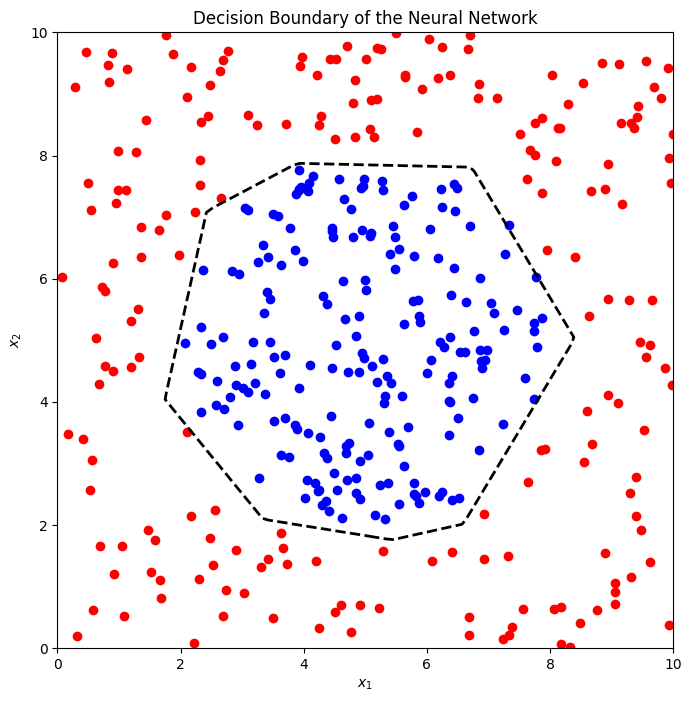

In [54]:
#@markdown #**Plot the data and the decision boundary**
#@markdown ---

model_3d.eval()
plot_decision_boundary(model_3d, points_inside, points_outside)

In [55]:
#@markdown #**Plot an interactive 3D representation of the model's latent space**
#@markdown ---

model_3d.eval()
plot_interactive_3d_latent_space(model_3d, custom_dataset.data, custom_dataset.labels)